<a href="https://colab.research.google.com/github/gmagannaDevelop/segnet/blob/mru_tests/example_notebooks/Model_abstraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MultiResUNet
## DCI-Net
#### Gustavo Magaña López

Creación de una clase que facilite el entrenamiento serializado de las arquitecturas encontradas en DCI-NET/segmed.

\########################################################

In [10]:
!ls

sample_data


In [11]:
!apt install jq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libjq1 libonig4
The following NEW packages will be installed:
  jq libjq1 libonig4
0 upgraded, 3 newly installed, 0 to remove and 7 not upgraded.
Need to get 276 kB of archives.
After this operation, 930 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libonig4 amd64 6.7.0-1 [119 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libjq1 amd64 1.5+dfsg-2 [111 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 jq amd64 1.5+dfsg-2 [45.6 kB]
Fetched 276 kB in 1s (358 kB/s)
Selecting previously unselected package libonig4:amd64.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../libon

In [12]:
## If changes are made to the repo, uninstall and
## a fresh pip install are required, so it seems.
#!pip uninstall segnet
!pip install git+https://github.com/gmagannaDevelop/segnet.git@mru_tests
##!pip install git+https://github.com/gmagannaDevelop/segnet.git@log_hotfix

  Cloning https://github.com/gmagannaDevelop/segnet.git (to revision mru_tests) to /tmp/pip-req-build-lz4yrbyj
  Running command git clone -q https://github.com/gmagannaDevelop/segnet.git /tmp/pip-req-build-lz4yrbyj
  Running command git checkout -b mru_tests --track origin/mru_tests
  Switched to a new branch 'mru_tests'
  Branch 'mru_tests' set up to track remote branch 'mru_tests' from 'origin'.
     |████████████████████████████████| 215kB 4.9MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 307kB 10.8MB/s 
     |████████████████████████████████| 747kB 16.7MB/s 
  Created wheel for segnet: filename=segnet-0.4-cp36-none-any.whl size=24725 sha256=467e2e324605d0bf56bae76ceeabe188e49cec046be27fb24d7d684b8ba4eaac
  Stored in directory: /tmp/pip-ephem-wheel-cache-i6473tbk/wheels/f1/c1/51/0ee27f445c3a618413714a84d4f5500547456389437a

Imports

In [13]:
### System-related
import sys
import os
import datetime 
from typing import Dict, Optional, List, Tuple, Any, NoReturn, Callable, Union, Type
#import importlib.util
###############################################################

### Machine learning specific
#import segmentation_models as sm
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import keras.models
import tensorflow as tf
###############################################################

### In-Out
from skimage import io as skio
import json 
import pandas as pd
import h5py
import glob
###############################################################

### Visualization
import seaborn as sns
###############################################################

### Numerical
import numpy as np
###############################################################

### Repo-specific (segnet)
from segnet.train import train_segnet
from segnet.models import unet
from segnet.models import multiresunet as mru
from segnet.models import multiresunet2 as mru2
from segnet.models import multiresunet3 as mru3
from segnet.utils import timing
from segnet.metrics import metrics as mts
#from segnet.segnet.train.train_segnet import train_segnet
#import segnet.segnet as segnet

### Data-related
from google.colab import drive, files
drive.mount('/content/drive/')
###############################################################


### Not an import, but mandatory to be defined here :
root_dir   = "drive/My Drive/DCI-Net"
_log_file  = os.path.join(root_dir, "time_logs.jsonl")

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Class definition

In [0]:
class Segmed(object):
  """
    Deep Learning Model Generator Object.
  """

  import os
  import matplotlib.pyplot as plt
  import tensorflow as tf
  from typing import Tuple, Optional, Union, Dict, Any, NoReturn

  @staticmethod
  def assert_isdir(path: str):
    """
      Returns argument `path` if it is a directory, 
      raises an exception otherwise.   
    """
    if os.path.isdir(path):
      return path
    else:
      raise Exception(f"Path '{path}' is not a directory.")
  
  @staticmethod
  def ls(path: str):
    """ Wrapper for os.listdir(path) """
    return os.listdir(path)

  def __init__(
      self, 
      model: tf.keras.Model,
      name: str,
      snapshot_dir: str,
      history_dir: str,
      data_path: str, 
      author: Optional[str] = None,
      seed: int = 1
  ) -> None:
    self._model = model
    self.__datetime: datetime.datetime = datetime.datetime.utcnow()
    self._date: str = str(self.__datetime).split(".")[0]
    self._name: str = name
    self._snapshot_dir: str = self.assert_isdir(snapshot_dir)
    self._history_dir: str = self.assert_isdir(history_dir)
    self._data_path: str = self.assert_isdir(data_path)
    self._img_path: str = os.path.join(self._data_path, 'imgs')
    self._msks_path: str = os.path.join(self._data_path, 'msks')
    self.__seed: int = 1
    if author is not None:
      self._author: str = author
    else:
      self._author: str = "Unknown"

  def __getitem__(self, key):
    return getattr(self, f"_{key}")

  @property
  def keys(self):
    """ Get the keys that can be used to index the Segmed object """
    return list(map(lambda x: x[1:], self.__dict__.keys()))

  @property
  def name(self):
    """ Name of the model, composed of: name-(author)-(date) """
    return f"{self._name}-({self._author})-({self._date})"

  @property
  def snapshot_file(self):
    """ Name (full path) of the model snapshot file (.h5 format) """
    return os.path.join(self._snapshot_dir, f"{self.name}.h5")

  @property
  def history_file(self):
    """ Name (full path) of the training history file (.csv format) """
    return os.path.join(self._history_dir, f"{self.name}.csv")

  @property
  def images_path(self):
    """ Path where images are stored. 
    Following the Keras convention it should contain a
    directory named `images`.
    """
    return self._img_path

  @property
  def masks_path(self):
    """ Path where segmentation masks are stored. 
    Following the Keras convention it should contain a
    directory named `masks`.
    """
    return self._msks_path

  @property
  def images(self):
    """ A list of all the images contained in `self.images_path`/images/ """
    return self.ls(os.path.join(self.images_path, 'images'))

  @property
  def masks(self):
    """ A list of all the segmentation masks contained in `self.masks_path`/masks/ """
    return self.ls(os.path.join(self.masks_path, 'masks'))
  
  @property
  def snapshots(self):
    """ List of files (snapshots) found in `self._snapshot_dir` """
    return self.ls(self._snapshot_dir)

  @property 
  def historiae(self):
    """ List of files (training histories) found in `self._history_dir` """
    return self.ls(self._history_dir)

  def train_test_generator(
      self, 
      data_gen_args: Optional[Dict[str, Any]] = None,
      hyper_params: Optional[Dict[str, Any]] =  None
  ) -> NoReturn:
    """ Generate the train/test split. 
      data_gen_args defaults to the following Dict :
        {
          "rescale": 1.0 / 255.0,
          "validation_split": 0.2,
          "dtype": tf.float32,
        }
    """
    # Rescale and convert to float32 both subsets
    if data_gen_args is None:
      self._data_gen_args = {
          "rescale": 1.0 / 255.0,
          "validation_split": 0.2,
          "dtype": tf.float32,
      }
    else:
      self._data_gen_args = data_gen_args

    if hyper_params is None:
      self._hyper_params = dict(
        batch_size = 8,
        epochs = 80,
        steps_per_epoch=10
      )

    # Crea the training generators with the defined transformations
    self.__image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**self._data_gen_args)
    self.__mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**self._data_gen_args)
    
    # Take images from directories
    self._image_generator_train = self.__image_datagen.flow_from_directory(
        self._img_path,
        class_mode=None,
        color_mode="rgb",
        batch_size=self._hyper_params["batch_size"],
        seed=self.__seed,
        subset="training",
    )
    self._mask_generator_train = self.__mask_datagen.flow_from_directory(
        self._msks_path,
        class_mode=None,
        color_mode="grayscale",
        batch_size=self._hyper_params["batch_size"],
        seed=self.__seed,
        subset="training",
    )
    # Combine both generators
    # This needs to be a generator of generators, see the following
    # https://github.com/tensorflow/tensorflow/issues/32357
    self._train_generator = (
        pair for pair in zip(self._image_generator_train, self._mask_generator_train)
    )

    # And now the validation generators
    self._image_generator_val = self.__image_datagen.flow_from_directory(
        self._img_path,
        class_mode=None,
        color_mode="rgb",
        batch_size=self._hyper_params["batch_size"],
        seed=self.__seed,
        subset="validation",
    )

    self._mask_generator_val = self.__mask_datagen.flow_from_directory(
        self._msks_path,
        class_mode=None,
        color_mode="grayscale",
        batch_size=self._hyper_params["batch_size"],
        seed=self.__seed,
        subset="validation",
    )

    # Combine both generators, with same issue as before
    self._val_generator = (
        pair for pair in zip(self._image_generator_val, self._mask_generator_val)
    )

  def show_img_and_mask(self, n: int = 5):
    # DEBUGGING ONLY, for checking that both image and maps are batched together
    if True:
      pass
    for _, i, j in zip(range(n), self._train_generator):
      plt.figure(0)
      plt.subplot(2, 1, 1)
      plt.imshow(i[0, ...])
      plt.subplot(2, 1, 2)
      plt.imshow(j[0, ..., 0])
      plt.show()



In [0]:
dataset_paths = {
    "isbi": "drive/My Drive/DCI-Net/Colab_data/ISBI_neural/structured", # Images as tiff volumes
    "colonoscopy": "drive/My Drive/DCI-Net/Colab_data/colonoscopy",     # Full original
    "dermoscopy80": "drive/My Drive/DCI-Net/Colab_data/dermoscopy80",   # reduced to 80 images
    "dermoscopy150": "drive/My Drive/DCI-Net/Colab_data/dermoscopy150", # reduced to 150, randomly 
                                                                          # sampled images.
    "chinese1": "drive/My Drive/DCI-Net/Colab_data/Dataset 2"           # Chinese dataset, Abdiel's
}

In [0]:
#_data_path  = dataset_paths["dermoscopy80"]
_historiae_dir = os.path.join(root_dir, "Historiae")
_model_snapshots_dir = os.path.join(root_dir, "ModelSnapshots")

In [0]:
hyper_params = dict(
    batch_size = 8,
    epochs = 80,
    steps_per_epoch=10
    #model_file = _model_log_path
)

In [0]:
x = Segmed(
    model=mru.MultiResUnet(), 
    name='multiresunet', 
    snapshot_dir=_model_snapshots_dir, 
    history_dir=_historiae_dir,
    data_path=dataset_paths["isbi"],
    author='yomero'
) 

In [36]:
for key in x.keys:
  print(key, "\t : \t", x[key])

model 	 : 	 <tensorflow.python.keras.engine.training.Model object at 0x7fa8dc6ecd68>
Segmed__datetime 	 : 	 2020-01-22 06:47:31.558730
date 	 : 	 2020-01-22 06:47:31
name 	 : 	 multiresunet
snapshot_dir 	 : 	 drive/My Drive/DCI-Net/ModelSnapshots
history_dir 	 : 	 drive/My Drive/DCI-Net/Historiae
data_path 	 : 	 drive/My Drive/DCI-Net/Colab_data/ISBI_neural/structured
img_path 	 : 	 drive/My Drive/DCI-Net/Colab_data/ISBI_neural/structured/imgs
msks_path 	 : 	 drive/My Drive/DCI-Net/Colab_data/ISBI_neural/structured/msks
Segmed__seed 	 : 	 1
author 	 : 	 yomero


In [37]:
x.train_test_generator()

Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


In [38]:
x.show_img_and_mask()

ValueError: ignored

In [0]:
# Declare the paths to use (following the Keras convention)
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit_generator

_model_log_path = os.path.join(
    _model_snapshots_dir, 
    yield_model_name(architecture="MultiResUNet")
)


Get the stored snapshots :

In [0]:
snapshots = os.listdir(_model_snapshots_dir)
snapshots[-5:]

['MultiResUNet-(Gustavo)-(2020-01-13 22:32:53).h5',
 'UNet-(segmed)-(2020-01-20 12:43:25).h5',
 'MultiResUNet-(Edwin)-(2020-01-20 12:43:25).h5',
 'MultiResUNet-(Gustavo)-(2020-01-20 12:43:25).h5',
 'MultiResUNet-(Original)-(2020-01-20 12:43:25).h5']

Choose a snapshot to load, if so desired :

In [0]:
load_snapshot = os.path.join(_model_snapshots_dir, snapshots[-1])
load_snapshot

'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Original)-(2020-01-20 12:43:25).h5'

En lugar de utilizar la función definida en el repositorio, copié el código aquí para poder modificarla fácilmente.

In [0]:
@timing.time_log(path_to_logfile="drive/My Drive/DCI-Net/time_logs.jsonl")
def new_train(
    model,
    img_path,
    mask_path,
    batch_size=16,
    epochs=25,
    steps_per_epoch=3125,
    val_split=0.2,
    optimizer=tf.keras.optimizers.Adam(),
    monitor="val_jaccard_index",
    model_file="unet_simple.h5",
    seed=1,
    show=False,
    **kw
):

    """
    Takes two paths for images and segmentation maps and rescales them, splits
    them into training and validation, while saving the best model trained.
    The paths must comply to the Keras API convention as specified in their
    documentation.

    Args:
        batch_size (int): Size of the batch to be processed.
        epochs (int): Number of epochs to train the model.
        steps_per_epoch (int): Total number of steps (batches of samples) to yield 
            before declaring one epoch finished and starting the next epoch.
        val_split (float): Value between 0.0 and 1.0 representing the size in percentage
            to split the dataset.
        optimizer (`Optimizer`): A Keras optimizer instance with a valid syntax from TensorFlow.
        monitor (str): Quantity to monitor during training; follow the Keras convention.
        model_file (str): File to create for the ModelCheckpoint callback from Keras.
        seed (int): Value to seed the ImageDataGenerator and always retrieve the same batch
            of pairs of images.
        show (bool): If true, plots a pair of size `batch_size` to see if the image and its
            segmentation maps are consistent. For debugging purposes only.
    """

    # Rescale and convert to float32 both subsets
    data_gen_args = {
        "rescale": 1.0 / 255.0,
        "validation_split": val_split,
        "dtype": tf.float32,
    }

    # Crea the training generators with the defined transformations
    image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)
    
    # Take images from directories
    image_generator_train = image_datagen.flow_from_directory(
        img_path,
        class_mode=None,
        color_mode="rgb",
        batch_size=batch_size,
        seed=seed,
        subset="training",
    )
    mask_generator_train = mask_datagen.flow_from_directory(
        mask_path,
        class_mode=None,
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
        subset="training",
    )
    # Combine both generators
    # This need to be a generator of generators, see the following
    # https://github.com/tensorflow/tensorflow/issues/32357
    train_generator = (
        pair for pair in zip(image_generator_train, mask_generator_train)
    )

    # And now the validation generators
    image_generator_val = image_datagen.flow_from_directory(
        img_path,
        class_mode=None,
        color_mode="rgb",
        batch_size=batch_size,
        seed=seed,
        subset="validation",
    )

    mask_generator_val = mask_datagen.flow_from_directory(
        mask_path,
        class_mode=None,
        color_mode="grayscale",
        batch_size=batch_size,
        seed=seed,
        subset="validation",
    )

    # Combine both generators, with same issue as before
    val_generator = (pair for pair in zip(image_generator_val, mask_generator_val))

    # DEBUGGING ONLY, for checking that both image and maps are batched together
    if show:
        import matplotlib.pyplot as plt

        for i, j in train_generator:
            plt.figure(0)
            plt.imshow(i[0, ...])
            plt.figure(1)
            plt.imshow(j[0, ..., 0])
            plt.show()

    # Define the checkpoint callback, always maximum mode for custom metrics
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        model_file, monitor=monitor, verbose=1, save_best_only=True, mode="max"
    )

    # Compile the model with an and custom metrics
    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=optimizer,
        metrics=[
                 mts.jaccard_index, mts.dice_coef, 
                 mts.O_Rate, mts.U_Rate, mts.Err_rate
        ]
    )

    # Create history of model and return it
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=[checkpoint],
        verbose=1,
        validation_data=val_generator,
        validation_steps=steps_per_epoch,
    )

    return history

In [0]:
__comments = (lambda x: [
              f"U-Net, SegMed's (Edwin's) implementation : models/unet.py, added for debugging purposes {x}",
              f"Edwin's implementation : models/multiresunet.py, {x}",
              f"Gustavo's implementation : models/multiresunet2.py, {x}",
              f"Original implementation : models/multiresunet3.py, {x}"
])("")

hyper_params = dict(
    batch_size = 8,
    epochs = 80,
    steps_per_epoch=10
    #model_file = _model_log_path
)

# DEBUG COMMENT OUT WHEN TRAINING : 
_debug_hyper_params = dict(
    batch_size = 8,
    epochs = 1,
    steps_per_epoch=2,
    model_file = _model_log_path
)

In [0]:
_model_authors = list(
    map(
        lambda x, y: os.path.join(_model_snapshots_dir, yield_model_name(architecture=x, _name=y)),
        ['UNet'] + 3*['MultiResUNet'],
        ['segmed', 'Edwin', 'Gustavo', 'Original'] 
        )
    )
_model_authors

['drive/My Drive/DCI-Net/ModelSnapshots/UNet-(segmed)-(2020-01-20 14:32:57).h5',
 'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Edwin)-(2020-01-20 14:32:57).h5',
 'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Gustavo)-(2020-01-20 14:32:57).h5',
 'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Original)-(2020-01-20 14:32:57).h5']


Instantiate a MultiResUNet model, **optionally** from a checkpoint :

In [0]:
models = [
  unet(),
  mru.MultiResUnet(),
  mru2.MultiResUNet(),
  mru3.MultiResUnet()
]
    
# TOGGLE THIS !
from_checkpoint = False

if from_checkpoint:
  # model1.load_weights(load_snapshot)
  # model2.load_weights(load_snapshot)
  pass

In [0]:
trainer = lambda x, y, z: new_train(
    x,
    _img_path,
    _masks_path,
    **hyper_params,
    model_file=y,
    show=False,
    _comment=z
)

Train the model :

In [0]:
__comments

["U-Net, SegMed's (Edwin's) implementation : models/unet.py, added for debugging purposes ",
 "Edwin's implementation : models/multiresunet.py, ",
 "Gustavo's implementation : models/multiresunet2.py, ",
 'Original implementation : models/multiresunet3.py, ']

In [0]:
os.listdir(os.path.join(img_path, 'imgs/images'))[-5:]

['ISIC_0000014.jpg',
 'ISIC_0000001.jpg',
 'ISIC_0000000.jpg',
 'ISIC_0000015.jpg',
 'ISIC_0000028.jpg']

In [0]:
historiae = list(map(trainer, models, _model_authors, __comments))

Found 64 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 16 images belonging to 1 classes.
Found 16 images belonging to 1 classes.
Epoch 1/80
10/10 [==============================] - 18s 2s/step - loss: 0.6476 - jaccard_index: 0.1830 - dice_coef: 0.3093 - O_Rate: 146970016.0000 - U_Rate: 0.0000e+00 - Err_rate: 146970016.0000

Epoch 00001: val_jaccard_index improved from -inf to 0.18303, saving model to drive/My Drive/DCI-Net/ModelSnapshots/UNet-(segmed)-(2020-01-20 14:32:57).h5
10/10 [==============================] - 70s 7s/step - loss: 7.6553 - jaccard_index: 0.2192 - dice_coef: 0.3524 - O_Rate: 217110992.0000 - U_Rate: 0.0000e+00 - Err_rate: 217110992.0000 - val_loss: 0.6476 - val_jaccard_index: 0.1830 - val_dice_coef: 0.3093 - val_O_Rate: 146970016.0000 - val_U_Rate: 0.0000e+00 - val_Err_rate: 146970016.0000
Epoch 2/80
10/10 [==============================] - 2s 191ms/step - loss: 0.5706 - jaccard_index: 0.1845 - dice_coef: 0.3111 - O_Rate: 147130512.00

In [0]:
_model_authors

['drive/My Drive/DCI-Net/ModelSnapshots/UNet-(segmed)-(2020-01-20 14:32:57).h5',
 'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Edwin)-(2020-01-20 14:32:57).h5',
 'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Gustavo)-(2020-01-20 14:32:57).h5',
 'drive/My Drive/DCI-Net/ModelSnapshots/MultiResUNet-(Original)-(2020-01-20 14:32:57).h5']

In [0]:
pandas_historiae = []

In [0]:
for history in historiae:
  pandas_historiae.append(pd.DataFrame(history.history))

In [0]:
for frame, author in zip(pandas_historiae, _model_authors):
  frame.to_csv(author.replace('h5', 'csv'))

In [0]:
\""}}{{{{{{{:#history = trainer(models[-2], _model_authors[-2], __comments[-2])

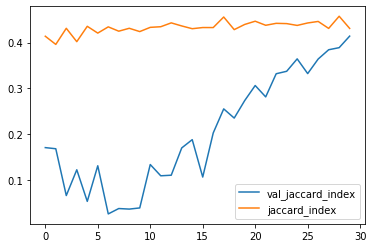

In [0]:
for key in ['val_jaccard_index', 'jaccard_index']:
  _ = history.history[key]
  sns.lineplot(list(range(len(_))), _, label=key)

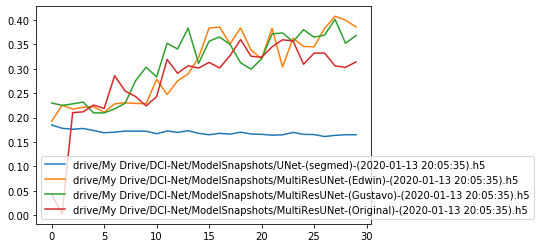

In [0]:
_jaccards = list(map(lambda x: x.history['val_jaccard_index'], historiae))
for _jaccard, _author in zip(_jaccards, _model_authors):
  sns.lineplot(list(range(len(_jaccard))), _jaccard, label=_author)

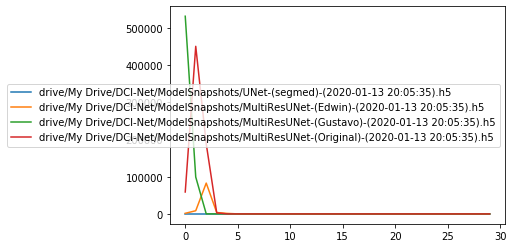

In [0]:
_losses = list(map(lambda x: x.history['val_loss'], historiae))
for _loss, _author in zip(_losses, _model_authors):
  sns.lineplot(list(range(len(_loss))), _loss, label=_author)

In [0]:
!cat "drive/My Drive/DCI-Net/time_logs.jsonl" | jq

/bin/bash: jq: command not found
cat: 'drive/My Drive/DCI-Net/time_logs.jsonl': No such file or directory


In [0]:
# 1 validación 5 pliegues
def 

In [0]:
@timing.time_log(path_to_logfile=_log_file)
def _dummy_debug_function(*args, **kw):
  pass
  

In [0]:
log

NameError: ignored

In [0]:
_dummy_debug_function(5, '234', 5.2, hola='pass', foo='bar')